# Classifying dolphin whistle sounds with a Convolutional Neural Network

This jupyter notebook creates a model, trains it and evaluates it.

This code is fully os-independent and fs-independent, so you don't have to worry whether you are running on a windows os or IOS or linux, they will all work. But do make sure you set up a virtual environment correctly before continuing.

**NB: Something that might seem counter-intuitive at first is that all "image shape" parameters in tensorflow and keras expect tuples in (heigh, width) order and not (width, height) or (x, y) as it was previously coded in Josh's jupyter notebook. This file does not use x and y to avoid any confusion.**
 
To understand why tensorflow expects (height, width) order and not the other way around read ahead: it has to do with the way nested loops and 2D arrays work. By convention, a 2D array has sub arrays lined up horizontally (as rows, or x). To loop through the 2D array we would do `for subarray in range(height)` (going down 2D array) then `for element in range(width)` (going across 2D array), effectively needing height, width in this order. 

Import relevant packages. Set up the virtual environment as specified in the README file to avoid "dependency-hell".

In [ ]:
# if you installed all the dependencies already, ignore this block of code
!pip3 install -r requirements.txt 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import layers, models 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate Training, Validation and Test Datasets

Here we generate training, validation datasets from the training data directory TRAIN_DATA_DIR and testing datasets from the testing data directory TEST_DATA_DIR

Before running the following cell, change the relative paths to the folders on your machine.

In [2]:
TRAINING_DATA_DIR = Path("/Users/matteohe/Desktop/DA/full-dclde-imgs/training-data")
TEST_DATA_DIR = Path("/Users/matteohe/Desktop/DA/full-dclde-imgs/testing-data")

HEIGHT, WIDTH = 202, 413
IMAGE_SHAPE = (HEIGHT, WIDTH) # target size in imagedatagenerators accept tuple of integers (height, width)
VALIDATION_SPLIT = 0.20 # validation split from the training data set

The default here is to keep the shuffle parameter to false, since it is pretty much pointless to shuffle the testing data as weights are not updated during the testing phase. But if you are testing something you should change it to true with the following caveat:

**NB: If you change the shuffle option in test_generator code to true (in case a metric you want to test requires the order to be shuffled), be mindful of what you did and definitely change the code in the bottom of this file in the Evaluation section, more specifically: the truth labels will need to be collected in a different way than it is right now in the classification report and confusion matrix code blocks.**

In [3]:
# create an imagedatagenerator object that helps split data into training and validation datasets
train_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=VALIDATION_SPLIT)

# create the training data generator
train_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    color_mode="grayscale",
)

# create the validation data generator
validation_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE,
    color_mode="grayscale",
)

# create the testing data generator
test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    directory=TEST_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
    color_mode="grayscale",
)


Found 4777 images belonging to 3 classes.
Found 1193 images belonging to 3 classes.
Found 2557 images belonging to 3 classes.


## Building a CNN model and stacking the layers

This section is dedicated to creating CNN models. \
Run either one of model1 and model2.
- Model 1 uses increasingly more filters further in the model. It also uses spatial dropout before the flattening layer to mitigate overfitting (written by Matteo)
- Model 2 is the original one by Josh and Gemma.

Configurations code for the model. There are a lot of things still worth exploring with the following model code. One thing that can be done is experimenting with dropout layers

In [4]:
KERNEL_SIZE = (3, 3) # 3x3 is the optimal size of a kernel 3x3 as agreed by the computing community
INPUT_SHAPE = (HEIGHT, WIDTH, 1) # the last channel is used to represent the shape of the pixels. if using rgb set to 3
LAYERS = 16
DROPOUT_RATE = 0.3

### Model 1

In [ ]:
# instantiate model object
model = models.Sequential()

model.add(
    layers.Conv2D(
        filters=LAYERS,
        kernel_size=KERNEL_SIZE,
        activation="relu",
        input_shape=INPUT_SHAPE,
    )
)
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(filters=LAYERS * 2, kernel_size=KERNEL_SIZE, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(filters=LAYERS * 4, kernel_size=KERNEL_SIZE, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.SpatialDropout2D(rate=DROPOUT_RATE))

model.add(layers.Flatten())
model.add(layers.Dense(units=LAYERS * 2, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=3, activation="softmax"))  # three final outputs (3 species)

model.summary()


### Model 2

In [5]:
# instantiate model object
model = models.Sequential()

# Stack layers on the sequential base model
model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu", input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(LAYERS, KERNEL_SIZE, activation="relu"))
model.add(layers.BatchNormalization())

# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation="softmax"))

# print out summary of code
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 411, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 200, 411, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 205, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 203, 16)       2320      
                                                                 
 batch_normalization_1 (Batc  (None, 98, 203, 16)      64        
 hNormalization)                                                 
                                                        

2022-04-06 10:43:26.071850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training the CNN model

Configurations code for the CNN training process.

In [6]:
# compile model
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"]
)

# Configurations
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
NUM_EPOCHS = 11
ES = EarlyStopping("val_loss", mode="auto", verbose=1, patience=5)

Train the network.

In [7]:
print("[INFO] training network for {} epochs...".format(NUM_EPOCHS))
fitted = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[ES],
)

[INFO] training network for 11 epochs...
Epoch 1/11
149/149 [==============================] - 141s 944ms/step - loss: 0.5856 - categorical_accuracy: 0.7760 - val_loss: 2.4656 - val_categorical_accuracy: 0.3767
Epoch 2/11
149/149 [==============================] - 141s 943ms/step - loss: 0.1165 - categorical_accuracy: 0.9646 - val_loss: 2.6569 - val_categorical_accuracy: 0.4645
Epoch 3/11
149/149 [==============================] - 141s 948ms/step - loss: 0.0451 - categorical_accuracy: 0.9907 - val_loss: 1.8236 - val_categorical_accuracy: 0.5177
Epoch 4/11
149/149 [==============================] - 141s 946ms/step - loss: 0.0246 - categorical_accuracy: 0.9954 - val_loss: 3.9119 - val_categorical_accuracy: 0.5642
Epoch 5/11
149/149 [==============================] - 141s 944ms/step - loss: 0.0461 - categorical_accuracy: 0.9874 - val_loss: 1.5888 - val_categorical_accuracy: 0.5887
Epoch 6/11
149/149 [==============================] - 141s 945ms/step - loss: 0.0206 - categorical_accuracy: 

# Evaluating the CNN model

### Validation and training accuracy history plot:

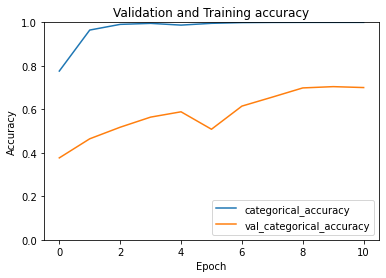

In [22]:
# Evalutate the network - use validation set
accuracy = "categorical_accuracy"
value_accuracy = "val_categorical_accuracy"
plt.plot(fitted.history[accuracy], label=accuracy)
plt.plot(fitted.history[value_accuracy], label=value_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Validation and Training accuracy")
plt.legend(loc="lower right")

### Validation and Training Loss History Plot:

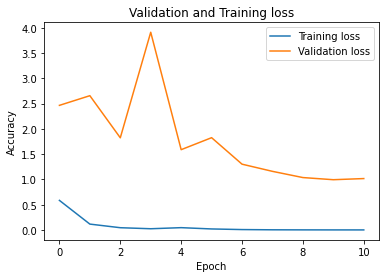

In [12]:
# Evalutate the network - use validation set
plt.plot(fitted.history["loss"], label="Training loss")
plt.plot(fitted.history["val_loss"], label="Validation loss")
plt.title("Validation and Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

### Testing the model with the testing dataset

In [15]:
print("[INFO] Testing with test-dataset ...")
loss, acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy is ", acc)
print("Test loss is ", loss)

[INFO] Testing with test-dataset ...
80/80 - 20s - loss: 0.5748 - categorical_accuracy: 0.8303 - 20s/epoch - 246ms/step
Test accuracy is  0.8302698731422424
Test loss is  0.5747528672218323


### Classification Report of the model

NB: the code below this point will not work and will produce misleading results if the test data is shuffled in the test_generator code. If you did that please change the way you get the predicted labels. You will most likely need to collect them by iterating through the test_generator to get the labels from all the batches. Of course it would be easier if the batch size includes all the data at once.

In [16]:
print("Running Classification Report...")
test_generator.reset()
# get the predicted scores for each class
scores = model.predict(test_generator)
# get the label with the highest prediction
predicted_labels = scores.argmax(axis=1)
# get ground truth labels from test_generator.classes
true_labels = test_generator.classes

# get species names
species = dict((v,k) for k,v in (train_generator.class_indices).items())
species_names = np.array(list(species.values()))

print(
    classification_report(
        true_labels, 
        predicted_labels, 
        target_names = species_names)
)

Running Classification Report...
              precision    recall  f1-score   support

  bottlenose       0.82      0.88      0.85       962
      common       0.85      0.80      0.82       914
melon-headed       0.83      0.80      0.81       681

    accuracy                           0.83      2557
   macro avg       0.83      0.83      0.83      2557
weighted avg       0.83      0.83      0.83      2557



### Confusion Matrix of the model

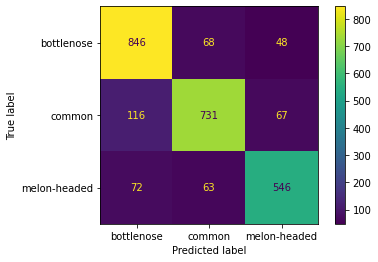

In [17]:
cm = confusion_matrix(true_labels, predicted_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
display.plot()

## Save
The current naming format has been decided to be "date-modelname".

In [1]:
from datetime import date
today = date.today()
today = str(today)

In [ ]:
# Save the trained model -> could save just the weights or the entire architecture
model_name = "-eric"
model.save(today + model_name + '.model')